# Understanding School Performance on Pennsylvania Standardized Tests

## Preprocessing and Baseline Modeling

objective of this notebook
- design matrix 
- build the simplest baseline model with results and metrics

### Contents:

1. Import packages and load data
2. assess pairwise collinearity
3. train test split
4. feature scaling
5. baseline modeling
6. plan for extended modeling


## 1. Import packages and load data

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# load cleaned data from csv file
df = pd.read_csv('../Data/school_data_1819_2.csv', index_col = 0)

In [3]:
# check data types
df.dtypes

SchoolName                                                             object
SchoolNumber                                                            int64
School Zip Code                                                         int64
DistrictName                                                           object
AUN                                                                     int64
Title I School                                                         object
Title I (Binary)                                                        int64
School Enrollment                                                       int64
Male (School)                                                         float64
Female (School)                                                       float64
Percent Regular Attendance (All Student)                              float64
American Indian/Alaskan Native                                        float64
Asian                                                           

The following features should <u>not</u> be recognized as numeric variables:
- SchoolNumber
- School Zip Code
- AUN

We will convert these into objects.

In [4]:
#convert columns to object
cols = ['SchoolNumber',
        'School Zip Code',
        'AUN']

for col in cols:
    df[col]=df[col].astype(str)

In [5]:
# establish design matrix, call it 'predictors'
predictors = df.drop(['SchoolName', \
                      'SchoolNumber', \
                      'School Zip Code', \
                      'DistrictName', \
                      'AUN', \
                      'Title I School', \
                      'Percent Proficient or Advanced ELA/Literature (All Student)', \
                      'Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)'], \
                     axis = 1) 

# target vectors
target_ELA = df['Percent Proficient or Advanced ELA/Literature (All Student)']
target_math = df['Percent Proficient or Advanced Mathematics/Algebra 1 (All Student)']

## 2. Assess pairwise collinearity

As we observed in the previous notebook, there are quite a few of our independent variables that are correlated with another.  With that in mind, there is concern that this may lead to overfitting and an increase in the error of our model. 

By looking at the pairwise collinearity of our variables, we can identify and place feature pairs in one of three buckets based on the correlation coefficients:

- $|r|$ is <b>0.5 or below:</b> low correlation
- $|r|$ is between <b>0.5 and 0.7:</b> mid correlation
- $|r|$ is <b>0.7 and above:</b> high correlation

We will look at the mid correlation and high correlation buckets and determine any features that may potentially be deleted and generate a list.

In our next notebook (extended modeling), we will train, test, and compare models with all features included vs highly correlated features removed.  We will also explore models such as ridge regression and LASSO regression that can introduce penalization on information that is redundant.

In [6]:
# Construct correlation matrix and take the absolute value of all correlation coefficients
corr_abs = predictors.corr().abs()

# Select upper triangle of correlation matrix
upper_corr_abs = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

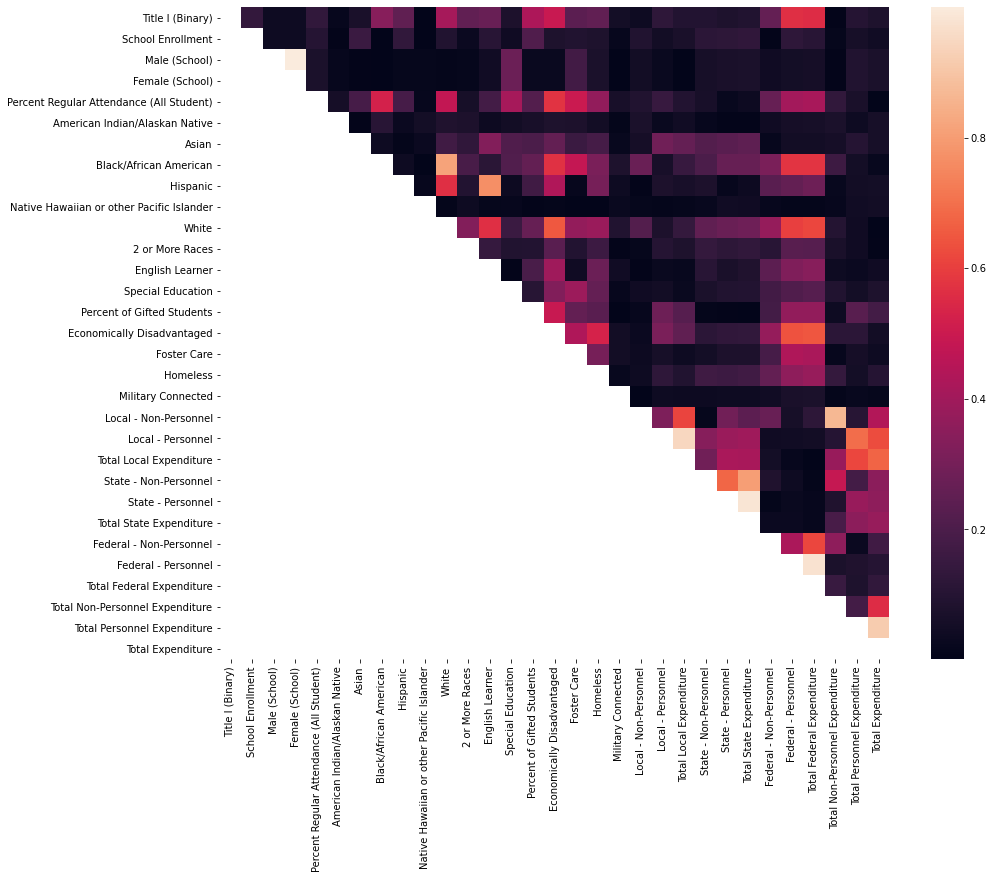

In [7]:
# plot the correlation heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(upper_corr_abs)
plt.show()

Looking at this heatmap of pairwise correlation, there definitely exist predictor variables that are highly correlated with another. 

We'll create three functions that will take this correlation matrix and identify which pairs of features are highly correlated, somewhat correlated, and not very correlated.

In [8]:
def high_corr(correlation_matrix, high_threshold):
    """creates a list of feature pairs as tuples that are highly correlated"""
    
    high_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > high_threshold:
                high_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return high_corr_list


def mid_corr(correlation_matrix, mid_threshold, high_threshold):
    """creates a list of feature pairs as tuples that are somewhat correlated"""
    
    mid_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] > mid_threshold and correlation_matrix.iloc[i][j] <= high_threshold:
                mid_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return mid_corr_list


def low_corr(correlation_matrix, mid_threshold):
    """creates a list of feature pairs as tuples that have low correlation"""
    
    low_corr_list = []
    
    for i in range(len(correlation_matrix)):
    #iterate through 'i' rows
    
        for j in range(len(correlation_matrix)):
        #iterate through 'j' columns
            if correlation_matrix.iloc[i][j] <= mid_threshold:
                low_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j], round(correlation_matrix.iloc[i][j], 4)))
    
    return low_corr_list

Now that we have the functions defined, we'll examine the pairwise collinearity of our dataset.

In [9]:
# create list of feature pairs with |r|<0.5
low_corr_pairs = low_corr(upper_corr_abs, 0.5)
low_corr_pairs

[('Title I (Binary)', 'School Enrollment', 0.1363),
 ('Title I (Binary)', 'Male (School)', 0.0385),
 ('Title I (Binary)', 'Female (School)', 0.0385),
 ('Title I (Binary)', 'Percent Regular Attendance (All Student)', 0.1328),
 ('Title I (Binary)', 'American Indian/Alaskan Native', 0.019),
 ('Title I (Binary)', 'Asian', 0.0689),
 ('Title I (Binary)', 'Black/African American', 0.3422),
 ('Title I (Binary)', 'Hispanic', 0.2471),
 ('Title I (Binary)', 'Native Hawaiian or other Pacific Islander', 0.0026),
 ('Title I (Binary)', 'White', 0.4123),
 ('Title I (Binary)', '2 or More Races', 0.2533),
 ('Title I (Binary)', 'English Learner', 0.2693),
 ('Title I (Binary)', 'Special Education', 0.0792),
 ('Title I (Binary)', 'Percent of Gifted Students', 0.43),
 ('Title I (Binary)', 'Economically Disadvantaged', 0.4959),
 ('Title I (Binary)', 'Foster Care', 0.2375),
 ('Title I (Binary)', 'Homeless', 0.2545),
 ('Title I (Binary)', 'Military Connected', 0.055),
 ('Title I (Binary)', 'Local - Non-Personn

In [10]:
# create list of feature pairs with 0.5<|r|<0.7
mid_corr_pairs = mid_corr(upper_corr_abs, 0.5, 0.7)
mid_corr_pairs

[('Title I (Binary)', 'Federal - Personnel', 0.564),
 ('Title I (Binary)', 'Total Federal Expenditure', 0.5554),
 ('Percent Regular Attendance (All Student)',
  'Black/African American',
  0.5249),
 ('Percent Regular Attendance (All Student)',
  'Economically Disadvantaged',
  0.5739),
 ('Black/African American', 'Economically Disadvantaged', 0.5677),
 ('Black/African American', 'Federal - Personnel', 0.5756),
 ('Black/African American', 'Total Federal Expenditure', 0.5777),
 ('Hispanic', 'White', 0.5649),
 ('White', 'English Learner', 0.566),
 ('White', 'Economically Disadvantaged', 0.6524),
 ('White', 'Federal - Personnel', 0.6012),
 ('White', 'Total Federal Expenditure', 0.6155),
 ('Economically Disadvantaged', 'Homeless', 0.5312),
 ('Economically Disadvantaged', 'Federal - Personnel', 0.6379),
 ('Economically Disadvantaged', 'Total Federal Expenditure', 0.6472),
 ('Local - Non-Personnel', 'Total Local Expenditure', 0.6102),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.69

In [11]:
# create list of feature pairs with |r|>0.7
high_corr_pairs = high_corr(upper_corr_abs, 0.7)
high_corr_pairs

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

As expected, we have a few feature pairs that are highly correlated.  Certainly the percentage of male students and percentage of female students will have a correlation coefficient that is close to, if not equal to -1.  We're also seeing that the percentage of black students and percentage of white students are also strongly correlated. 

Most of the high correlation feature pairs are a result of the various 'Total' expenditure columns that we created during EDA.  

Among the <b>second</b> element of the high correlation pairs, the only total that seems to be missing is 'Total Personnel Expenditure'.  We notice that when we look at the mid-correlation pairs, that 'Local - Personnel' and 'Total Personnel Expenditure' have a correlation coefficient of 0.694.  

If we are removing our engineered 'Total' expenditure features, it may make sense to remove all of them.  As a result, we will run our function again, but with a threshold of 0.69.

In [12]:
high_corr_pairs_2 = high_corr(upper_corr_abs, 0.69)
high_corr_pairs_2

[('Male (School)', 'Female (School)', 1.0),
 ('Black/African American', 'White', 0.8143),
 ('Hispanic', 'English Learner', 0.7677),
 ('Local - Non-Personnel', 'Total Non-Personnel Expenditure', 0.8637),
 ('Local - Personnel', 'Total Local Expenditure', 0.9461),
 ('Local - Personnel', 'Total Personnel Expenditure', 0.694),
 ('State - Non-Personnel', 'Total State Expenditure', 0.8016),
 ('State - Personnel', 'Total State Expenditure', 0.9832),
 ('Federal - Personnel', 'Total Federal Expenditure', 0.9747),
 ('Total Personnel Expenditure', 'Total Expenditure', 0.9164)]

We'll create a list of features to potentially delete.  To do so, we'll select the second feature from each tuple pair.

Then, we'll create a new design matrix without these features.

In [13]:
# create an empty list of features to potentially delete
corr_features = []

# iterate through our high_corr_pairs list and add the second item of each tuple to our corr_features list
for tup in high_corr_pairs_2:
    corr_features.append(tup[1])

In [14]:
# use the 'set' data structure to elimnate any duplicates
corr_features = list(set(corr_features))
corr_features

['Total Expenditure',
 'Total Federal Expenditure',
 'Total Personnel Expenditure',
 'English Learner',
 'White',
 'Female (School)',
 'Total Non-Personnel Expenditure',
 'Total State Expenditure',
 'Total Local Expenditure']

In [15]:
# create new design matrix with these features deleted
predictors_2 = predictors.drop(corr_features, axis = 1)

## 3. Train Test Split

80/20 split

2 design matrices, all features and high corr features removed

2 approaches of scaling, original and standard scaler

2 models, math and ela

8 models in total

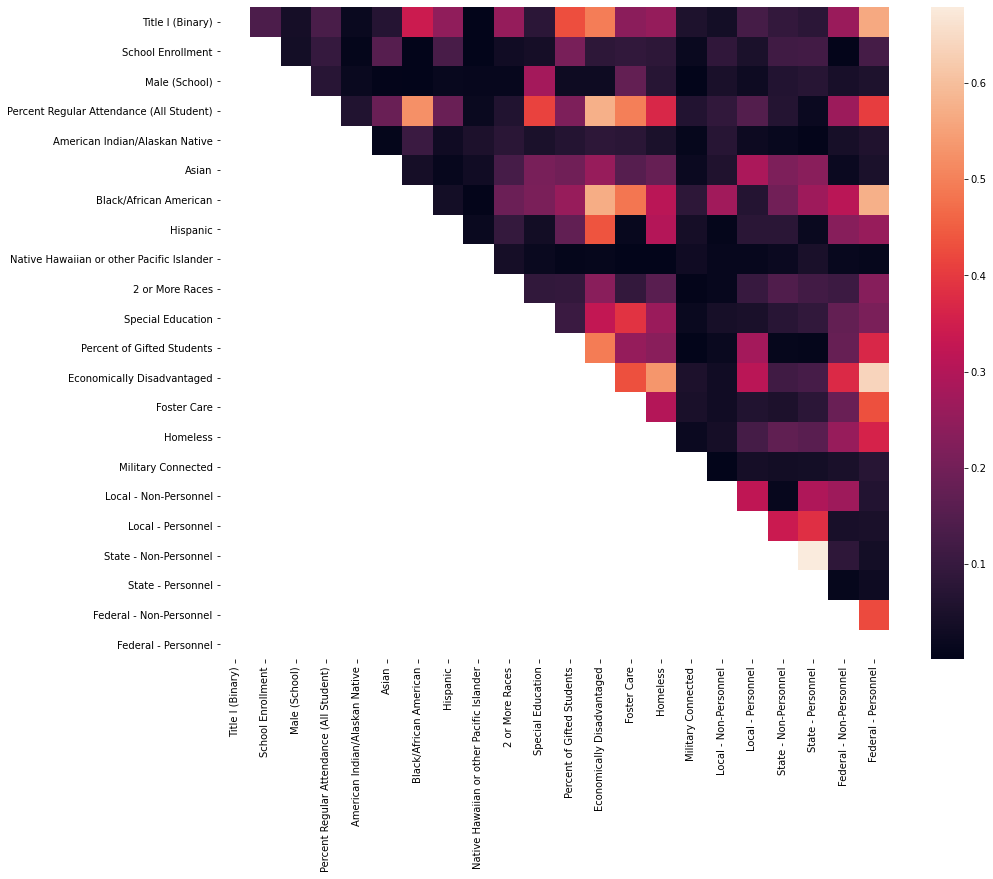

In [49]:
# plot the correlation heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(upper_corr_abs_2)
plt.show()

In [16]:
#Check partition sizes with 80/20 train/test split
print(len(predictors) * .8, len(predictors) * .2)
print(len(predictors_2) * .8, len(predictors_2) * .2)

2138.4 534.6
2138.4 534.6


### All features, unscaled

In [17]:
# create train test split with original predictors and ELA as the target variable
X_train_ELA, X_test_ELA, y_train_ELA, y_test_ELA = train_test_split(predictors, 
                                                                    target_ELA, 
                                                                    test_size=0.2, 
                                                                    random_state=16)

In [18]:
#check partition size
X_train_ELA.shape, X_test_ELA.shape

((2138, 31), (535, 31))

In [19]:
#check partition size
y_train_ELA.shape, y_test_ELA.shape

((2138,), (535,))

In [20]:
# create train test split with original predictors and math as the target variable
X_train_math, X_test_math, y_train_math, y_test_math = train_test_split(predictors, 
                                                                    target_math, 
                                                                    test_size=0.2, 
                                                                    random_state=16)

Since we are using the same random state for both of these train/test splits, X_train_ELA and X_train_math should be identical, and the same should hold true for X_test_ELA and X_test_math.  But we will check to be sure.

In [21]:
#confirm that X_train_ELA and X_train_math are equivalent dataframes

from pandas.testing import assert_frame_equal

assert_frame_equal(X_train_ELA, X_train_math)

In [22]:
#confirm that X_test_ELA and X_test_math are equivalent dataframes
assert_frame_equal(X_test_ELA, X_test_math)

Since we've confirmed that these dataframes are equal, we will simply use X_train and X_test to refer to both of them, for simplicity.

In [23]:
X_train = X_train_ELA
X_test = X_test_ELA

### High correlation features removed, unscaled

In [24]:
# create train test split with high correlation predictors removed and ELA as the target variable
X_train_rem, X_test_rem, y_train_ELA, y_test_ELA = train_test_split(predictors_2, 
                                                                    target_ELA, 
                                                                    test_size=0.2, 
                                                                    random_state=16)

In [25]:
# create train test split with high correlation predictors removed and math as the target variable
X_train_rem, X_test_rem, y_train_math, y_test_math = train_test_split(predictors_2, 
                                                                    target_math, 
                                                                    test_size=0.2, 
                                                                    random_state=16)

## 4. Feature Scaling

Apply standard scaler since some of our variables do not have a defined maximum value (namely our expenditures).

To prevent potentially leaking information from our test set into the model, we will fit the scaler on only the training data and then standardize both the training and test sets with this scaler.

First, we will fit and apply the scaler to our original X_train and X_test datasets, which still retains all of our highly correlated features.

In [26]:
# instantiate standard scaler
sc1 = StandardScaler()

# fit the scaler on the training set and transform it
X_train_sc = sc1.fit_transform(X_train)

# transform the test set
X_test_sc = sc1.transform(X_test)

Next, we will fit and apply another scaler to our X_train_rem and X_test_rem datasets, which do NOT contain our highly correlated features.

In [27]:
# instantiate standard scaler
sc2 = StandardScaler()

# fit the scaler on the training set and transform it
X_train_rem_sc = sc2.fit_transform(X_train_rem)

# transform the test set
X_test_rem_sc = sc2.transform(X_test_rem)

## 5. Baseline Modeling

For our initial baseline models, we will be using Linear Regression.  We will test the different combinations of training with all the features vs with highly correlated features removed and unscaled vs scaled.  We will also train two models for each combination, one where the target variable is Percent Proficient or Advanced in ELA and the other Percent Proficient or Advanced in Math.

As a result, we have 8 models to train and test.  The table below shows all of the combinations, as well as the corresponding datasets used to train and test.

| Features | Scaling | Subject | X train | X test | y train | y test |
| --- | --- | --- | --- | --- | --- | --- |
| All features | Unscaled | ELA | X_train | X_test | y_train_ELA | y_test_ELA |
| All features | Unscaled | Math | X_train | X_test | y_train_math | y_test_math |
| All features | Scaled | ELA | X_train_sc | X_test_sc | y_train_ELA | y_test_ELA |
| All features | Scaled | Math | X_train_sc | X_test_sc | y_train_math | y_test_math |
| Highly correlated features removed | Unscaled | ELA | X_train_rem | X_test_rem | y_train_ELA | y_test_ELA |
| Highly correlated features removed | Unscaled | Math | X_train_rem | X_test_rem | y_train_math | y_test_math |
| Highly correlated features removed | Scaled | ELA | X_train_rem_sc | X_test_rem_sc | y_train_ELA | y_test_ELA |
| Highly correlated features removed | Scaled | Math | X_train_rem_sc | X_test_rem_sc | y_train_math | y_test_math |

For easier comparison, we will set up a table to compare metrics and define a function that will add the metrics of each model to this table.

In [28]:
# set up column names for metrics table
column_names = ["Features", "Scaling", "Subject", "Train r2", "Train MAE", "Train MSE", "Test r2", "Test MAE", "Test MSE"]

# create dataframe for metrics table with column names listed above
metrics = pd.DataFrame(columns = column_names)

In [29]:
def add_metrics(Features, Scaling, Subject, y_train, y_train_pred, y_test, y_test_pred):
    
    new_row = {'Features':Features,
               'Scaling':Scaling,
               'Subject':Subject,
               'Train r2': r2_score(y_train, y_train_pred),
               'Train MAE': mean_absolute_error(y_train, y_train_pred),
               'Train MSE': mean_squared_error(y_train, y_train_pred),
               'Test r2': r2_score(y_test, y_test_pred),
               'Test MAE': mean_absolute_error(y_test, y_test_pred),
               'Test MSE': mean_squared_error(y_test, y_test_pred)}
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

### 5a. All features, unscaled

In [30]:
# instantiate LinearRegression for ELA
lr1_ELA = LinearRegression()

#fit on training data for ELA
lr1_ELA.fit(X_train, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred = lr1_ELA.predict(X_train)
y_test_ELA_pred = lr1_ELA.predict(X_test)

In [31]:
add_metrics('All features', 'Unscaled', 'ELA', y_train_ELA, y_train_ELA_pred, y_test_ELA, y_test_ELA_pred)

In [32]:
# instantiate LinearRegression for math
lr1_math = LinearRegression()

#fit on training data for math
lr1_math.fit(X_train, y_train_math)

# predict on train set and test set
y_train_math_pred = lr1_math.predict(X_train)
y_test_math_pred = lr1_math.predict(X_test)

In [33]:
add_metrics('All features', 'Unscaled', 'Math', y_train_math, y_train_math_pred, y_test_math, y_test_math_pred)

### 5b. All features, scaled

In [89]:
metrics

,Features,Scaling,Subject,Train r2,Train MAE,Train MSE,Test r2,Test MAE,Test MSE
0,All features,Unscaled,ELA,0.817979,6.3468,67.542195,0.786248,6.7753,78.457189


In [34]:
# instantiate LinearRegression for ELA
lr2_ELA = LinearRegression()

#fit on training data for ELA
lr2_ELA.fit(X_train_sc, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred2 = lr2_ELA.predict(X_train_sc)
y_test_ELA_pred2 = lr2_ELA.predict(X_test_sc)

In [35]:
add_metrics('All features', 'Scaled', 'ELA', y_train_ELA, y_train_ELA_pred2, y_test_ELA, y_test_ELA_pred2)

In [36]:
# instantiate LinearRegression for math
lr2_math = LinearRegression()

#fit on training data for ELA
lr2_math.fit(X_train_sc, y_train_math)

# predict on train set and test set
y_train_math_pred2 = lr2_math.predict(X_train_sc)
y_test_math_pred2 = lr2_math.predict(X_test_sc)

In [37]:
add_metrics('All features', 'Scaled', 'Math', y_train_math, y_train_math_pred2, y_test_math, y_test_math_pred2)

### 5c. Highly correlated features removed, unscaled

In [38]:
# instantiate LinearRegression for ELA
lr3_ELA = LinearRegression()

#fit on training data for ELA
lr3_ELA.fit(X_train_rem, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred3 = lr3_ELA.predict(X_train_rem)
y_test_ELA_pred3 = lr3_ELA.predict(X_test_rem)

In [39]:
add_metrics('Highly correlated features removed', 'Unscaled', 'ELA', y_train_ELA, y_train_ELA_pred3, y_test_ELA, y_test_ELA_pred3)

In [40]:
# instantiate LinearRegression for math
lr3_math = LinearRegression()

#fit on training data for ELA
lr3_math.fit(X_train_rem, y_train_math)

# predict on train set and test set
y_train_math_pred3 = lr3_math.predict(X_train_rem)
y_test_math_pred3 = lr3_math.predict(X_test_rem)

In [41]:
add_metrics('Highly correlated features removed', 'Unscaled', 'Math', y_train_math, y_train_math_pred3, y_test_math, y_test_math_pred3)

### 5d. Highly correlated features removed, scaled

In [42]:
# instantiate LinearRegression for ELA
lr4_ELA = LinearRegression()

#fit on training data for ELA
lr4_ELA.fit(X_train_rem_sc, y_train_ELA)

# predict on train set and test set
y_train_ELA_pred4 = lr4_ELA.predict(X_train_rem_sc)
y_test_ELA_pred4 = lr4_ELA.predict(X_test_rem_sc)

In [43]:
add_metrics('Highly correlated features removed', 
            'Scaled', 
            'ELA', 
            y_train_ELA, 
            y_train_ELA_pred4, 
            y_test_ELA, 
            y_test_ELA_pred4
           )


In [44]:
# instantiate LinearRegression for math
lr4_math = LinearRegression()

#fit on training data for math
lr4_math.fit(X_train_rem_sc, y_train_math)

# predict on train set and test set
y_train_math_pred4 = lr4_math.predict(X_train_rem_sc)
y_test_math_pred4 = lr4_math.predict(X_test_rem_sc)

In [45]:
add_metrics('Highly correlated features removed', 'Scaled', 'Math', y_train_math, y_train_math_pred4, y_test_math, y_test_math_pred4)


In [46]:
metrics

,Features,Scaling,Subject,Train r2,Train MAE,Train MSE,Test r2,Test MAE,Test MSE
0,All features,Unscaled,ELA,0.817979,6.346800,67.542195,0.786248,6.775300,78.457189
1,All features,Unscaled,Math,0.692955,9.810908,149.014700,0.655520,10.215045,164.926789
2,All features,Scaled,ELA,0.799005,6.677475,74.582629,0.771052,6.948462,84.034624
3,All features,Scaled,Math,0.700370,9.679650,145.416010,0.655321,10.117124,165.021946
4,Highly correlated features removed,Unscaled,ELA,0.813733,6.440508,69.117565,0.779964,6.867509,80.763622
5,Highly correlated features removed,Unscaled,Math,0.699401,9.694240,145.886500,0.656550,10.095536,164.433747
6,Highly correlated features removed,Scaled,ELA,0.813733,6.440508,69.117565,0.779964,6.867509,80.763622
7,Highly correlated features removed,Scaled,Math,0.699401,9.694240,145.886500,0.656550,10.095536,164.433747


If we are looking at school performance in ELA, our best linear regression model takes into account <u>all features</u> and does <b>not</b> scale the data. This model has the highest test $r^2$ score, and the lowest test MAE and test MSE.

If we are looking at school performance in Math, our best linear regression model has the highly correlated features removed.  Interestingly, when we remove our highly correlated features, our model 

This model has the highest test $r^2$ score, and the lowest test MAE and test MSE.

## 6. Plan for extended modeling

linear regression
ridge regression
LASSO regression

